Статья на хабре: [Методы отбора фич](https://habr.com/post/264915/)

# 1. Imports

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline

In [3]:
from sklearn.datasets import load_breast_cancer, load_wine

# 2. Data
## 2.1. Data Import

In [4]:
train_f = open('../data/arcene/arcene_train.data')
data_train = [line.split(' ') for line in train_f]

valid_f = open('../data/arcene/arcene_valid.data')
data_valid = [line.split(' ') for line in valid_f]

In [5]:
train_labels = open('../data/arcene/arcene_train.labels')
y_train = [int(line.replace('\n', '')) for line in train_labels]

valid_labels = open('../data/arcene/arcene_valid.labels')
y_valid = [int(line.replace('\n', '')) for line in valid_labels]

In [6]:
df_train = pd.DataFrame(data_train)
df_valid = pd.DataFrame(data_valid)

In [7]:
df_train.drop(columns=10000, inplace=True)
df_valid.drop(columns=10000, inplace=True)

In [8]:
df_train = df_train.astype(int)
df_valid = df_valid.astype(int)

In [9]:
df_train.shape
df_train.head()
df_valid.shape
df_valid.head()

(100, 10000)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,71,0,95,0,538,404,20,0,0,...,255,570,86,0,36,0,80,0,0,524
1,0,41,82,165,60,554,379,0,71,0,...,213,605,69,7,473,0,57,0,284,423
2,0,0,1,40,0,451,402,0,0,0,...,235,593,28,0,24,0,90,0,34,508
3,0,56,44,275,14,511,470,0,0,0,...,91,600,0,26,86,0,102,0,0,469
4,105,0,141,348,0,268,329,0,0,1,...,813,0,0,0,0,190,301,0,0,354


(100, 10000)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,0,156,138,2,635,444,0,1,0,...,88,692,42,0,50,67,87,0,0,465
1,0,7,0,7,0,251,0,0,22,222,...,698,673,0,0,18,201,317,0,34,199
2,0,32,0,470,53,493,0,0,140,147,...,267,461,20,34,165,225,53,0,47,219
3,0,77,0,202,0,432,472,0,60,0,...,181,555,13,0,488,0,71,0,177,487
4,0,34,102,522,2,474,473,0,39,0,...,114,630,0,29,192,0,74,0,5,416


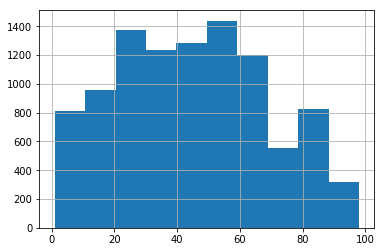

In [10]:
df_train.nunique().hist()

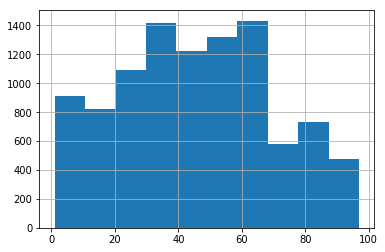

In [11]:
df_valid.nunique().hist()

In [12]:
mask_train = (df_train.nunique() == 1)
mask_train.shape

(10000,)

In [13]:
df_train = df_train.loc[:, ~mask_train]
df_valid = df_valid.loc[:, ~mask_train]

df_train.shape
df_valid.shape

(100, 9920)

(100, 9920)

In [14]:
df_train.dtypes.unique()
df_valid.dtypes.unique()

array([dtype('int64')], dtype=object)

array([dtype('int64')], dtype=object)

In [15]:
df_train = df_train.values
df_valid = df_valid.values

In [16]:
df_valid

array([[  0,   0, 156, ...,   0,   0, 465],
       [  0,   7,   0, ...,   0,  34, 199],
       [  0,  32,   0, ...,   0,  47, 219],
       ...,
       [ 93,  32, 137, ...,   0, 276, 312],
       [119,  12, 198, ...,   0,   0, 350],
       [112,  19, 171, ...,   0,   0, 367]])

# Filters
## Informaition gain

Формула энтропии:

$$H(X) = - \sum_{x_i \in X}{p(x_i)} * \log_{2}{p(x_i)}$$

где, $p(x_i)$ — вероятность того, что переменная $X$ примет значение $x_i$.

В задаче классификации эта вероятность равна относительной частоте классов. Другими словами количество наблюдений, в которых $X = x_i$, поделенное на общее число наблюдений.

<font color='red'>
Чтобы лучше понять смысл этой меры, можно представить два простых примера. Во-первых, подбрасывание монетки, у которой выпадение орла и решки равновероятны. В этом случае энтропия, рассчитанная по формуле, будет равна 1. Если же монета всегда падает исключительно орлом вверх, то энтропия будет равна 0. Иными словами высокая энтропия говорит о равномерном распределении, низкая — о каком-то более интересном.
    
Для расчета корреляции между переменными нам понадобится определить еще несколько мер. Первая из них — specific conditional entropy:
</font>
$$H(Y|X = x_i)$$

<font color='red'>
— энтропия H(Y) посчитанная только для тех записей, для которых $X = x_i$.
</font>

Формула относительной энтропии (conditional entropy):

$$H(Y|X) = \sum_{x_i \in X}{p(x_i)} * H(Y|X = x_i)$$

<font color='red'>
Интересная такая величина не сама по себе, а ее разница с обычной энтропией фичи Y. Т.е. мера того, насколько более упорядоченной становится для нас переменная Y, если мы знаем значения X. Или, говоря проще, существует ли корреляция между значениями X и Y, и насколько она велика. Об этом говорит величина information gain:
</font>

$$IG(Y|X) = H(Y) - H(Y|X)$$

<font color='red'>
Чем больше параметр IG — тем сильнее корреляция. Таким образом, мы легко можем вычислить information gain для всех фич и выкинуть те, которые слабо влияют на целевую переменную. Тем самым, во-первых, сократив время расчета модели, а, во-вторых, уменьшив опасность переобучения.
</font>

In [17]:
def entropy(arr, base=None):
    length = len(arr)
    uniqs, freqs = np.unique(arr, return_counts=True)
    # 
    probs = freqs / length
    # 
    log_probs = np.log(probs)
    # 
    if base:
        log_probs /= np.log(base)
    H = -sum(probs * log_probs)
    return H

def spec_cond_entropy(arr, feature, value):
    if value in feature:
        mask = (feature == value)
        return entropy(arr[mask])
    else:
        print('There is no this value in feature')
        
def cond_entropy(arr, feature):
    length = len(feature)
    uniqs, freqs = np.unique(feature, return_counts=True)
    # 
    probs = freqs / length
    #
    H_YX_xi = np.array([spec_cond_entropy(arr, feature, uniq) for uniq in uniqs])
    H_YX = sum(probs * H_YX_xi)
    return H_YX

def information_gain(arr, feature):
    H_Y = entropy(arr)
    H_YX = cond_entropy(arr, feature)
    IG_YX = H_Y - H_YX
    return IG_YX

def mutual_info_cl(X, y):
    '''
    Only discrete features
    '''
    X, y = np.asarray(X), np.asarray(y)
    mut_inf = np.array([information_gain(y, feature) for feature in X.T])
    
    return mut_inf

In [18]:
ig_arr = mutual_info_cl(df_train, y_train)

ig_arr

array([0.37523112, 0.37908166, 0.36122611, ..., 0.03382271, 0.38330344,
       0.62001306])

In [19]:
ig_arr.argsort()[::-1]

array([3327, 6522, 6572, ..., 3929,  462, 8823])

In [20]:
from sklearn.feature_selection import mutual_info_classif

In [43]:
%%time
mut_inf = mutual_info_classif(df_train, y_train, discrete_features=True)

CPU times: user 9.65 s, sys: 112 ms, total: 9.76 s
Wall time: 9.94 s


In [22]:
mut_inf

array([0.37523112, 0.37908166, 0.36122611, ..., 0.03382271, 0.38330344,
       0.62001306])

In [23]:
np.argsort(mut_inf)[::-1]

array([3327, 6522, 6600, ..., 4484, 1126,  273])

## Spearman corellation coefficient

$$\rho (x, y) = \frac{\sum_{i}{(x_{i} - \bar{x_{j}}}) (y_{i} - \bar{y})}{\sqrt{\sum_{i}{(x_{i} - \bar{x_{j}}})^2 \sum_{i}(y_{i} - \bar{y})^2}}$$

In [24]:
def spearmen_rank_correlation(x_arr, y_arr):
    x_mean, y_mean = np.mean(x_arr), np.mean(y_arr)
    x_arr_centr = (x_arr - x_mean)
    y_arr_centr = (y_arr - y_mean)
    
    nominator = sum(x_arr_centr * y_arr_centr)
    denominator = np.sqrt(sum(x_arr_centr ** 2) * sum(y_arr_centr ** 2))
    
    return nominator / denominator

In [25]:
corr_lst = np.array([spearmen_rank_correlation(x, y_train) for x in df_train.T])
abs_corr_lst = np.abs(corr_lst)

order = np.argsort(abs_corr_lst)[::-1]

corr_lst_ordered = corr_lst[order]

In [26]:
order
corr_lst_ordered

array([4253,  686, 8431, ...,   76, 5806, 5681])

array([-4.73911782e-01, -4.72367395e-01, -4.70263341e-01, ...,
        6.68670815e-05, -5.96609264e-05,  6.46039110e-18])

# Modeling

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
cls_rf = RandomForestClassifier(random_state=112358)

In [29]:
cls_rf.fit(df_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=112358, verbose=0,
            warm_start=False)

In [30]:
cls_rf.score(df_valid, y_valid)

0.74

In [31]:
np.sort(cls_rf.feature_importances_)[::-1]

array([0.04196525, 0.03375363, 0.02583207, ..., 0.        , 0.        ,
       0.        ])

## PCA

In [32]:
from sklearn.decomposition import PCA

In [33]:
pca = PCA(n_components=0.9, random_state=112358)

In [45]:
pca.n_components_

19

In [34]:
X_train_pca = pca.fit_transform(df_train)

In [35]:
X_valid_pca = pca.transform(df_valid)

In [36]:
cls_rf.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=112358, verbose=0,
            warm_start=False)

In [37]:
cls_rf.score(X_valid_pca, y_valid)

0.78

## Filter

In [38]:
n_components = 500
X_train_filtered = df_train[:, ig_arr.argsort()[::-1]][:, :n_components]
X_valid_filtered = df_valid[:, ig_arr.argsort()[::-1]][:, :n_components]

In [39]:
cls_rf.fit(X_train_filtered, y_train)
cls_rf.score(X_valid_filtered, y_valid)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=112358, verbose=0,
            warm_start=False)

0.75

## Correlation

In [40]:
n_components = 400
X_train_corr = df_train[:, order[:n_components]]
X_valid_corr = df_valid[:, order[:n_components]]

In [41]:
cls_rf.fit(X_train_corr, y_train)
cls_rf.score(X_valid_corr, y_valid)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=112358, verbose=0,
            warm_start=False)

0.78

# Draft

In [42]:
mask_nan = np.isnan(corr_lst_ordered)

order_pure = order[~mask_nan]

In [175]:
# corr_lst[order_pure]
corr_lst_ordered[~mask_nan]

array([-4.73911782e-01, -4.72367395e-01, -4.70263341e-01, ...,
        6.68670815e-05, -5.96609264e-05,  6.46039110e-18])

In [176]:
order_pure

array([4289,  697, 8501, ...,   76, 5860, 5732])

In [178]:
order_pure

array([4289,  697, 8501, ...,   76, 5860, 5732])